# TP 3 : TOMOGRAPHY
## [Imen AYADI]

In [1]:
# imports
import sys,os
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse
import scipy.sparse.linalg as linalg
from scipy.io import loadmat
import time

##<font color='red'> 1. X-ray tomography</font>

### <font color='green'>1.1 Loading data</font>

In [40]:
!wget -nc --user ECP --password Optim http://www-syscom.univ-mlv.fr/~chouzeno/ECP/Slides/data.zip
!unzip -n data.zip

H = loadmat('data/H.mat')['H']
xbar = loadmat('data/x.mat')['x'].reshape(-1)
print('Done.')

File ‘data.zip’ already there; not retrieving.

Archive:  data.zip
Done.


### <font color="green">1.2 Construction of sinogram for standard white gaussian noise

In [3]:
M, N = H.shape
print("M = ",M)
print("N = ",N)
w = np.random.normal(0,1,M)
y = H @ xbar + w

M =  16200
N =  8100


### <font color="green"> 1.3 Displaying the sinogram and the absorption image

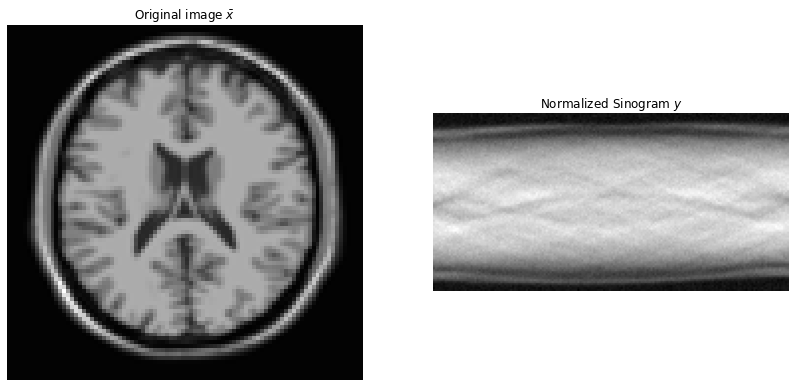

In [4]:
plt.figure(figsize=(14,14))
plt.subplot(1,2,1)
plt.imshow(xbar.reshape(90,90, order='F'),cmap="gray")
plt.title('Original image $\\bar{x}$')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(y.reshape(90,180, order='F'),cmap="gray")
plt.title('Normalized Sinogram $y$')
plt.axis('off')

plt.show()

##<font color='red'> 2. Optimization problem</font>

###<font color='green'> 2.1 Loading the gradient operator</font>

In [5]:
G = loadmat('data/G.mat')['G']
print('Done.')
print("Verify the dimension of G : " ,G.shape, "= ( 2 *",N,",",N,") ==> YES")

Done.
Verify the dimension of G :  (16200, 8100) = ( 2 * 8100 , 8100 ) ==> YES


###<font color='green'> 2.2 Lipschitz constant of $f$</font>

In [6]:
lbda, delta = 0.13, 0.02

_, H_eigvals, _ = linalg.svds(H)
_, G_eigvals, _ = linalg.svds(G)

L = H_eigvals[-1]**2 + lbda/(delta**2)*G_eigvals[-1]**2
print('L =',L )
print("Is H degenerate? : ", 0 in H_eigvals)
print("Is G degenerate? : ", 0 in G_eigvals)

L = 18092.773276864806
Is H degenerate? :  False
Is G degenerate? :  False


##<font color='red'> 3. Optimization Algorithms </font>


### <font color="green"> 3.0 Defining the penalized objective function and its derivative</font>

In [7]:
#initiamization
x0=np.zeros(N)

In [8]:
#stopping criterion tolerance
eps = np.sqrt(N)*1e-4

In [9]:
#objective function and its derivative
def psi_(delta):
  return lambda u: np.sqrt(1 + (u/delta)**2)

def psi_prime_(delta):
  return lambda u: (u/delta**2)/np.sqrt(1 + (u/delta)**2)

def f_(delta,lbda):
    return lambda x : 0.5*np.linalg.norm(H @ x - y)**2 + lbda * np.sum(psi_(delta)(G @ x))

def grad_r(x,delta):
    Gx = G @ x
    grad = Gx / psi_(delta)(Gx) @ G
    return grad

def grad_f_(delta,lbda):
    return lambda x:  H.T @ (H @ x - y) + lbda/(delta**2) * grad_r(x,delta)

psi = psi_(delta)
psi_prime = psi_prime_(delta)
f = f_(delta,lbda)
grad_f = grad_f_(delta,lbda)

###<font color="green"> 3.1 gradient descent 

In [10]:
def gradient_descent(x0, f, grad_f, lr, eps = eps,max_iter=int(1e5),printing=True):
    x_seq = [x0]
    iteration = 0
    test = True
    while (iteration < max_iter) and test:
        x = x_seq[-1] - lr * grad_f(x_seq[-1])
        test = np.linalg.norm(grad_f(x)) > eps
        if ((iteration+1) % 200 == 0 or iteration == max_iter-1 or not (test)) and printing:
            print("iter {}:  \tf(x) = {:.8f}\t||∇f(x)|| = {:.8f}".format(iteration + 1, f(x), np.linalg.norm(grad_f(x))))
        if printing and not (test)  :
            print("The stopping criterion was reached, stopping now")
            break
        iteration +=1        
        x_seq.append(x)
    return x_seq

In [11]:
print("The gradient descent algorithm is running :")
start = time.time()
x_GD_seq = gradient_descent(x0, f, grad_f, lr=1.99/L)
time_GD = time.time()-start
np.save('GD_values.npy', np.array([f(y) for y in x_GD_seq]))
np.save('GD_time.npy', np.array([time_GD]))
print("The required time for running in seconds: ", time_GD)

The gradient descent algorithm is running :
iter 200:  	f(x) = 12845.52604572	||∇f(x)|| = 48.21284386
iter 400:  	f(x) = 12830.20449065	||∇f(x)|| = 11.02189003
iter 600:  	f(x) = 12829.16774554	||∇f(x)|| = 3.66936610
iter 800:  	f(x) = 12829.03193536	||∇f(x)|| = 1.51661016
iter 1000:  	f(x) = 12829.00642038	||∇f(x)|| = 0.70115201
iter 1200:  	f(x) = 12829.00069072	||∇f(x)|| = 0.34364072
iter 1400:  	f(x) = 12828.99927147	||∇f(x)|| = 0.17471364
iter 1600:  	f(x) = 12828.99889674	||∇f(x)|| = 0.09110420
iter 1800:  	f(x) = 12828.99879328	||∇f(x)|| = 0.04837714
iter 2000:  	f(x) = 12828.99876378	||∇f(x)|| = 0.02603593
iter 2200:  	f(x) = 12828.99875516	||∇f(x)|| = 0.01415570
iter 2351:  	f(x) = 12828.99875297	||∇f(x)|| = 0.00898357
The stopping criterion was reached, stopping now
The required time for running in seconds:  61.94424748420715


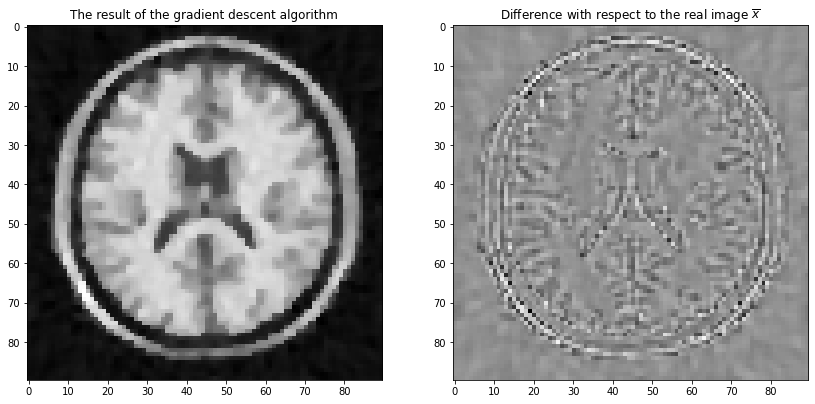

In [12]:
plt.figure(figsize=(14,14))
plt.subplot(121)
plt.imshow(x_GD_seq[-1].reshape(90,90, order='F'),cmap='gray')
plt.title("The result of the gradient descent algorithm")
plt.subplot(122)
plt.imshow(xbar.reshape(90,90, order='F')- x_GD_seq[-1].reshape(90,90, order='F'),cmap='gray')
plt.title("Difference with respect to the real image $\overline{x}$")
plt.show()
plt.show()

###<font color =green> 3.2 MM quadratic algorithm


In [13]:
HtH = H.T @ H

def A_(x,lbda,delta):
    coef = lbda / (delta ** 2)
    diag = scipy.sparse.diags(1 / psi_(delta)(G @ x)).tocsc()

    def curvature(v):
        return HtH @ v + coef * (G.T @ (diag @ (G @ v)))

    return linalg.LinearOperator((N, N), matvec=curvature, rmatvec=curvature)

A = lambda x : A_(x,lbda,delta)

In [14]:
def Quadratic_MM(x0, f, grad_f, A , eps = eps,max_iter=int(1e5), printing=True):
    x_seq = [x0]
    iteration = 0
    test =True
    while test and (iteration < max_iter):
        x = x_seq[-1] - linalg.bicg(A(x_seq[-1]), grad_f(x_seq[-1]))[0]
        test = np.linalg.norm(grad_f(x)) > eps
        if printing and ((iteration+1) % 10 == 0 or iteration == max_iter-1 or test==False):
            print("iter {}:  \tf(x) = {:.8f}\t||∇f(x)|| = {:.8f}".format(iteration + 1, f(x), np.linalg.norm(grad_f(x))))
        if printing and (test==False):
            print("The stopping criterion was reached, stopping now")
            break
        iteration +=1
        x_seq.append(x)
    return x_seq

In [15]:
print("The quadratic MM algorithm is running :")
start = time.time()
x_QMM_seq = Quadratic_MM(x0, f, grad_f, A )
time_QMM = time.time()-start
np.save('QMM_values.npy', np.array([f(y) for y in x_QMM_seq]))
np.save('QMM_time.npy', np.array([time_QMM]))
print("The required time for running in seconds : ", time_QMM)

The quadratic MM algorithm is running :
iter 10:  	f(x) = 12830.57354377	||∇f(x)|| = 15.83583289
iter 20:  	f(x) = 12829.04131619	||∇f(x)|| = 2.11257172
iter 30:  	f(x) = 12829.00146115	||∇f(x)|| = 0.48734810
iter 40:  	f(x) = 12828.99898168	||∇f(x)|| = 0.13672241
iter 50:  	f(x) = 12828.99877429	||∇f(x)|| = 0.04194921
iter 60:  	f(x) = 12828.99875399	||∇f(x)|| = 0.01366752
iter 64:  	f(x) = 12828.99875255	||∇f(x)|| = 0.00884327
The stopping criterion was reached, stopping now
The required time for running in seconds :  464.8829553127289


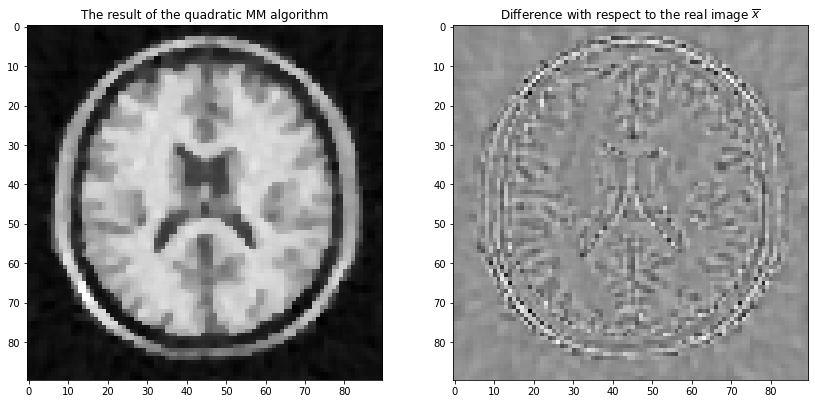

In [16]:
plt.figure(figsize=(14,14))
plt.subplot(121)
plt.imshow(x_QMM_seq[-1].reshape(90,90, order='F'),cmap='gray')
plt.title("The result of the quadratic MM algorithm")
plt.subplot(122)
plt.imshow(xbar.reshape(90,90, order='F')- x_QMM_seq[-1].reshape(90,90, order='F'),cmap='gray')
plt.title("Difference with respect to the real image $\overline{x}$")
plt.show()

###<font color="green"> 3.3 Accelerating the MM algorithm : memory gradient 

In [17]:
def MMMG(x0, f, grad_f, psi, coef ,eps=eps , max_iter=int(1e5),printing=True):
    x_seq = [x0]
    D = - grad_f(x_seq[-1])[:,np.newaxis]
    grad = grad_f(x0)
    iteration =0
    test = True
    while (iteration < max_iter) and test:
        HD = H @ D
        GD = G @ D
        DAD = HD.T @ HD + coef * GD.T @ scipy.sparse.diags(1 / psi(G @ x_seq[-1])).tocsc() @ GD
        # avoid dimensions errors on first iteration
        if DAD.ndim == 0:
            DAD = DAD.reshape(1,1)
        u = -scipy.linalg.pinv(DAD) @ D.T @ grad
        x = x_seq[-1] + D @ u
        grad = grad_f(x)
        test =  np.linalg.norm(grad) > eps
        if printing and (not (test) or (iteration+1) % 50 == 0 or iteration == max_iter - 1):
            print("iter {}:  \tf(x) = {:.8f}\t||∇f(x)|| = {:.8f}".format(iteration+ 1, f(x), np.linalg.norm(grad)))
        if printing and (not (test)):
            print("The stopping criterion was reached, stopping now")
            break        
        D = - np.vstack((grad, x - x_seq[-1])).T
        x_seq.append(x)
        iteration +=1
    return x_seq

In [18]:
print("The 3MG algorithm is running :")
start = time.time()
coef = lbda/(delta**2)
x_3MG_seq = MMMG(x0, f, grad_f, psi,coef )
time_3MG = time.time() - start
np.save('3MG_values.npy', np.array([f(y) for y in x_3MG_seq]))
np.save('3MG_time.npy', np.array([time_3MG]))
print("The required time for running in seconds : ", time_3MG)

The 3MG algorithm is running :
iter 50:  	f(x) = 12829.22719650	||∇f(x)|| = 11.69070253
iter 100:  	f(x) = 12828.99885343	||∇f(x)|| = 0.18459268
iter 139:  	f(x) = 12828.99875166	||∇f(x)|| = 0.00858117
The stopping criterion was reached, stopping now
The required time for running in seconds :  6.493516445159912


In [19]:
f(x0)-f(x_GD_seq[-1])

6826239.863712051

In [20]:
1-(min(H_eigvals)**2/L)**2

0.9495283147887126

In [21]:
np.log(1-2*1.99*(min(H_eigvals)**2/L)*(1-1.99/2))

-0.004480738470500162

In [22]:
16*1.1847/0.05

379.104

In [23]:
np.log((N*1e-8)/ (2*L*6833036.1479))/np.log(1-0.01*1.99*(min(H_eigvals)**2/L))

7957.339254140773

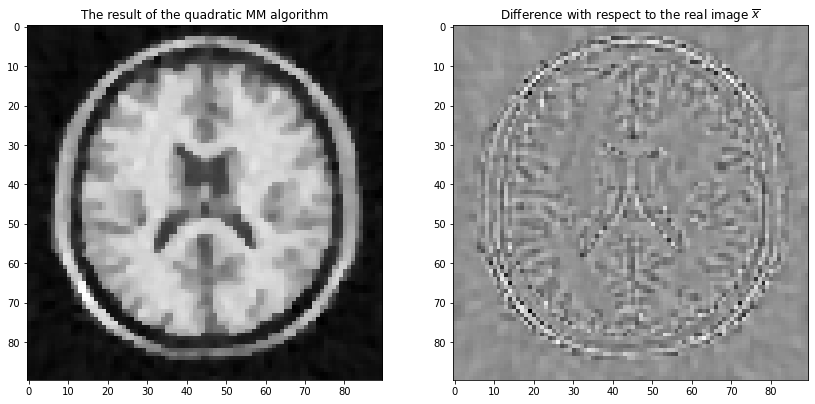

In [24]:
plt.figure(figsize=(14,14))
plt.subplot(121)
plt.imshow(x_3MG_seq[-1].reshape(90,90, order='F'),cmap='gray')
plt.title("The result of the quadratic MM algorithm")
plt.subplot(122)
plt.imshow(xbar.reshape(90,90, order='F')- x_3MG_seq[-1].reshape(90,90, order='F'),cmap='gray')
plt.title("Difference with respect to the real image $\overline{x}$")
plt.show()

### <font color="green"> 3.4 Block-coordinate MM quadratic algorithm

In [25]:
def get_cols(A, j, Nj):
    return A[...,j*Nj:(j+1)*Nj]

def Aj_(x, j, Nj ,lbda ,delta ):
    coef = lbda / (delta ** 2)
    Gj, Hj = get_cols(G, j, Nj), get_cols(H, j, Nj)
    diag = scipy.sparse.diags(1 / psi_(delta)(Gj @ x)).tocsc()

    def curvature(v):
        return Hj.T @ (Hj @ v) + coef * (Gj.T @ (diag @ (Gj @ v)))

    return linalg.LinearOperator((Nj,Nj), matvec=curvature, rmatvec=curvature)

Aj = lambda x, j, Nj  : Aj_(x, j, Nj ,lbda ,delta )

In [26]:
def BMMQ(x0, f, grad_f, Aj, K,eps=eps ,max_iter=int(1e5),printing=True):
    Nj = N // K
    x_seq = [x0]
    iteration =0
    test = True
    while (iteration < max_iter) and test:
        x =x_seq[-1].copy()
        j = iteration % K
        xj, gradj = get_cols(x, j, Nj), get_cols(grad_f(x), j, Nj)
        xj -= linalg.bicg(Aj(xj, j, Nj), gradj)[0]
        test = np.linalg.norm(grad_f(x)) > eps
        if printing and ((iteration +1) % 50 == 0 or iteration == max_iter-1 or not (test)):
            print("iter {}:  \tf(x) = {:.5f}\t||∇f(x)||={:.5f}".format(iteration + 1, f(x), np.linalg.norm(grad_f(x))))
        if printing and not (test):
            print("The stopping criterion was reached, stopping now")
            break
        x_seq.append(x)
        iteration +=1
    return x_seq

In [34]:
X_BMMQ_seqs = []
times_BMMQ=[]
for K in [2, 3, 5, 6, 9]:
    print('Block coordinate MM algorithm is running for K =', K)
    start = time.time()
    X_BMMQ_seqs.append( BMMQ(x0, f, grad_f, Aj, K))
    times_BMMQ.append(time.time() - start)
    np.save('BMMQ_K='+str(K)+'_values.npy', np.array([f(y) for y in X_BMMQ_seqs[-1]]))
    np.save('BMMQ_K='+str(K)+'_time.npy', np.array([times_BMMQ[-1]]))
    print("The required time for running in seconds : ", times_BMMQ[-1])
    print()

Block coordinate MM algorithm is running for K = 2
iter 50:  	f(x) = 12829.01719	||∇f(x)||=2.01737
iter 100:  	f(x) = 12828.99878	||∇f(x)||=0.04696
iter 131:  	f(x) = 12828.99875	||∇f(x)||=0.00874
The stopping criterion was reached, stopping now
The required time for running in seconds :  52.537768840789795

Block coordinate MM algorithm is running for K = 3
iter 50:  	f(x) = 12829.88053	||∇f(x)||=28.59923
iter 100:  	f(x) = 12829.00277	||∇f(x)||=0.56935
iter 150:  	f(x) = 12828.99882	||∇f(x)||=0.06971
iter 200:  	f(x) = 12828.99875	||∇f(x)||=0.01080
iter 205:  	f(x) = 12828.99875	||∇f(x)||=0.00887
The stopping criterion was reached, stopping now
The required time for running in seconds :  53.06967782974243

Block coordinate MM algorithm is running for K = 5
iter 50:  	f(x) = 12903.42854	||∇f(x)||=458.60560
iter 100:  	f(x) = 12829.16068	||∇f(x)||=6.30170
iter 150:  	f(x) = 12829.00510	||∇f(x)||=0.78538
iter 200:  	f(x) = 12828.99920	||∇f(x)||=0.19513
iter 250:  	f(x) = 12828.99879	||∇

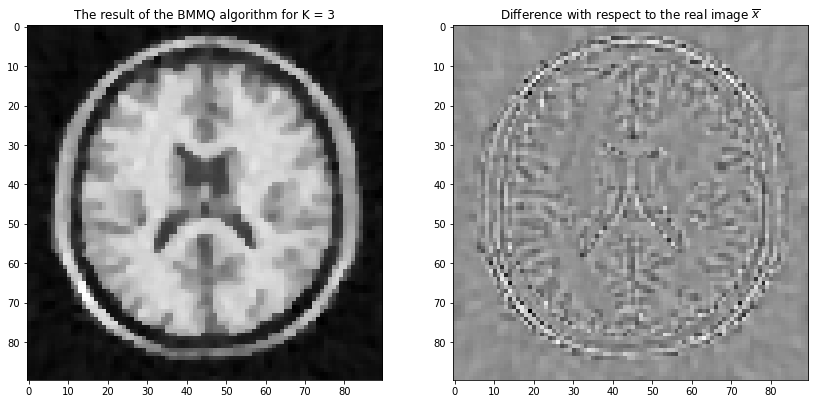

In [28]:
plt.figure(figsize=(14,14))
plt.subplot(121)
plt.imshow(X_BMMQ_seqs[1][-1].reshape(90,90, order='F'),cmap='gray')
plt.title("The result of the BMMQ algorithm for K = 3")
plt.subplot(122)
plt.imshow(xbar.reshape(90,90, order='F')- X_BMMQ_seqs[1][-1].reshape(90,90, order='F'),cmap='gray')
plt.title("Difference with respect to the real image $\overline{x}$")
plt.show()

### <font color="green"> 3.5 Parallel MM quadratic algorithm

In [30]:
G_abs, H_abs = np.abs(G), np.abs(H)
G_sum = scipy.sparse.diags(G_abs.toarray().sum(axis=1)).tocsc()
H_sum = scipy.sparse.diags(H_abs.toarray().sum(axis=1)).tocsc()
G_cal, H_cal = G_sum @ G_abs, H_sum @ H_abs
H_cal_sum = H_cal.sum(axis=0)
coef = lbda / (delta ** 2)


def invB_(x,delta,lbda):
    # B(x)^{-1} is stored as a vector instead of a diagonal matrix
    coef = lbda / (delta ** 2)
    return np.asarray(1/(H_cal_sum + coef * G_cal.T @ (1 / psi_(delta)(G @ x)))).squeeze()

invB = lambda x : invB_(x,delta,lbda)

def Parallel_MM(x0, f, grad_f,invB,eps=eps ,max_iter=int(1e5),printing=True):
    x_seq = [x0]
    test = True
    iteration = 0
    while (iteration < max_iter) and test : 
        x = x_seq[-1] - invB(x_seq[-1]) * grad_f(x_seq[-1])
        test = np.linalg.norm(grad_f(x)) > eps
        if printing and (iteration % 200 == 0 or iteration  == max_iter-1 or not (test)) :
            print("iter {}:  \tf(x) = {:.5f}\t||∇f(x)|| = {:.5f}".format(iteration + 1, f(x), np.linalg.norm(grad_f(x))))
        if printing and not (test):
            print("The stopping criterion was reached, stopping now")
            break
        x_seq.append(x)
        iteration +=1
    return x_seq

In [31]:
print("The parallel MM algorithm is running :")
start = time.time()
x_PMM_seq = Parallel_MM(x0, f, grad_f,invB )
time_PMM = time.time() - start
np.save('PMM_values.npy', np.array([f(y) for y in x_PMM_seq]))
np.save('PMM_time.npy', np.array([time_PMM]))
print("The required time for running in seconds : ", time_PMM)

The parallel MM algorithm is running :
iter 1:  	f(x) = 547618.41468	||∇f(x)|| = 85242.36691
iter 201:  	f(x) = 12911.79609	||∇f(x)|| = 133.38231
iter 401:  	f(x) = 12840.32501	||∇f(x)|| = 39.58092
iter 601:  	f(x) = 12831.46374	||∇f(x)|| = 16.76992
iter 801:  	f(x) = 12829.68188	||∇f(x)|| = 8.17052
iter 1001:  	f(x) = 12829.22063	||∇f(x)|| = 4.38707
iter 1201:  	f(x) = 12829.07911	||∇f(x)|| = 2.51776
iter 1401:  	f(x) = 12829.03015	||∇f(x)|| = 1.51863
iter 1601:  	f(x) = 12829.01169	||∇f(x)|| = 0.94905
iter 1801:  	f(x) = 12829.00429	||∇f(x)|| = 0.60816
iter 2001:  	f(x) = 12829.00119	||∇f(x)|| = 0.39702
iter 2201:  	f(x) = 12828.99985	||∇f(x)|| = 0.26295
iter 2401:  	f(x) = 12828.99926	||∇f(x)|| = 0.17619
iter 2601:  	f(x) = 12828.99899	||∇f(x)|| = 0.11919
iter 2801:  	f(x) = 12828.99886	||∇f(x)|| = 0.08128
iter 3001:  	f(x) = 12828.99880	||∇f(x)|| = 0.05581
iter 3201:  	f(x) = 12828.99878	||∇f(x)|| = 0.03854
iter 3401:  	f(x) = 12828.99876	||∇f(x)|| = 0.02674
iter 3601:  	f(x) = 128

###<font color="green">3.6  Comparison of the optimization methods

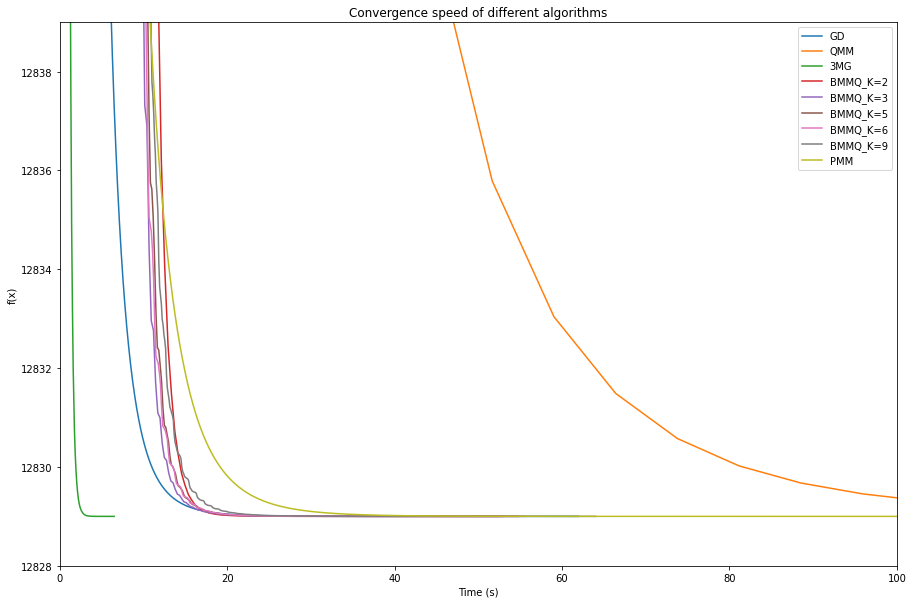

In [41]:
#compare the convergence speed of the algorithms for the same stopping criterion 
plt.figure(figsize=(15,10))
mins = []
for algo in ['GD','QMM','3MG','BMMQ_K=2','BMMQ_K=3','BMMQ_K=5','BMMQ_K=6','BMMQ_K=9','PMM']:
    try:
        t = np.load(algo+'_time.npy')
        f_list = np.load(algo+'_values.npy')
        mins.append(f_list[-1])
    except OSError:
        continue
    t_list = np.linspace(0, t[0], len(f_list))
    plt.plot(t_list, f_list, label=algo)
plt.legend()
plt.title('Convergence speed of different algorithms')
plt.xlabel('Time (s)')
plt.ylabel('f(x)')
plt.xlim(0, 100)
plt.ylim(min(mins)-1, max(mins)+10)
plt.show()

In [39]:
SNR = lambda x: 10*np.log10(np.sum(xbar**2)/np.sum((x-xbar)**2))


In [47]:
lambda_values = np.linspace(0.1, 1, 10)
delta_values = np.linspace(0.01, 0.1, 10)
max=-np.infty

for l in lambda_values:
    for d in delta_values:
        coef = l/(d**2)
        f = f_(d,l)
        grad_f = grad_f_(d,l)
        psi = psi_(d)
        print('λ = {:.1f}  \tδ = {:.2f}'.format(l, d), end='\t')
        x = MMMG(x0, f, grad_f,psi,coef,eps=eps,printing=False )[-1]
        print('SNR: {:.5f}'.format(SNR(x)))
        if SNR(x) > max:
          max = SNR(x)
          l_opt = l
          d_opt = d

λ = 0.1  	δ = 0.01	SNR: 18.21073
λ = 0.1  	δ = 0.02	SNR: 18.73398
λ = 0.1  	δ = 0.03	SNR: 18.13313
λ = 0.1  	δ = 0.04	SNR: 17.21186
λ = 0.1  	δ = 0.05	SNR: 16.27761
λ = 0.1  	δ = 0.06	SNR: 15.43356
λ = 0.1  	δ = 0.07	SNR: 14.69933
λ = 0.1  	δ = 0.08	SNR: 14.06618
λ = 0.1  	δ = 0.09	SNR: 13.51792
λ = 0.1  	δ = 0.10	SNR: 13.03870
λ = 0.2  	δ = 0.01	SNR: 16.90014
λ = 0.2  	δ = 0.02	SNR: 18.53398
λ = 0.2  	δ = 0.03	SNR: 18.97517
λ = 0.2  	δ = 0.04	SNR: 18.87348
λ = 0.2  	δ = 0.05	SNR: 18.47780
λ = 0.2  	δ = 0.06	SNR: 17.94140
λ = 0.2  	δ = 0.07	SNR: 17.35477
λ = 0.2  	δ = 0.08	SNR: 16.76808
λ = 0.2  	δ = 0.09	SNR: 16.20695
λ = 0.2  	δ = 0.10	SNR: 15.68269
λ = 0.3  	δ = 0.01	SNR: 15.78613
λ = 0.3  	δ = 0.02	SNR: 17.90027
λ = 0.3  	δ = 0.03	SNR: 18.78169
λ = 0.3  	δ = 0.04	SNR: 19.10842
λ = 0.3  	δ = 0.05	SNR: 19.09825
λ = 0.3  	δ = 0.06	SNR: 18.87160
λ = 0.3  	δ = 0.07	SNR: 18.51479
λ = 0.3  	δ = 0.08	SNR: 18.08766
λ = 0.3  	δ = 0.09	SNR: 17.62986
λ = 0.3  	δ = 0.10	SNR: 17.16643
λ = 0.4  	

In [48]:
print("The optimal parameters are λ = ",l_opt," and \tδ = ",d_opt," with SNR = ",max)

The optimal parameters are λ =  1.0  and 	δ =  0.1  with SNR =  19.441300121059136
